In [40]:
from models.model_builder import load_model
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchinfo import summary
import os
from util import find_files_in_folder
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import yaml
from models.lindsey import LindseyNet
from models.retinal import RetinalModel
import palettable
import matplotlib as mpl

# Weights Development

In [52]:
model_base_path = "../models/spd_level/l3-2"#"../models/spd/retinal_spd"
logfile = os.path.join(os.path.split(model_base_path)[0],"logs",os.path.split(model_base_path)[1]+".yaml")
if os.path.exists(logfile):
    with open(logfile, "r") as file:
        log = yaml.load(file, Loader=yaml.FullLoader)
if os.path.isdir(model_base_path):
    files = find_files_in_folder(model_base_path, "e**.pth")
    params = []
    pgroups = []
    for i, model_path in enumerate(files[:]):
        model = load_model(model_base_path, weights_file=model_path)
        pgroups.append([p.detach().cpu().flatten() for p in model.parameters()])
        params.append(torch.cat(pgroups[-1]))
    params = torch.stack(params)
else:
    model = load_model(model_base_path)
    pgroups = [[p.detach().cpu().flatten() for p in model.parameters()]]
    params = torch.cat(pgroups[-1])

In [53]:
summary(model, (1, model.in_channels, *model.img_size))

Layer (type:depth-idx)                   Output Shape              Param #
RetinalModel                             [1, 10]                   --
├─Sequential: 1-1                        [1, 7744]                 --
│    └─SpaceToDepth: 2-1                 [1, 12, 60, 60]           --
│    └─Conv2d: 2-2                       [1, 16, 58, 58]           1,744
│    └─ELU: 2-3                          [1, 16, 58, 58]           --
│    └─SpaceToDepth: 2-4                 [1, 64, 29, 29]           --
│    └─Conv2d: 2-5                       [1, 32, 27, 27]           18,464
│    └─ELU: 2-6                          [1, 32, 27, 27]           --
│    └─Conv2d: 2-7                       [1, 32, 27, 27]           1,056
│    └─ELU: 2-8                          [1, 32, 27, 27]           --
│    └─SpaceToDepth: 2-9                 [1, 128, 14, 14]          --
│    └─Conv2d: 2-10                      [1, 64, 11, 11]           131,136
│    └─ELU: 2-11                         [1, 64, 11, 11]           --


In [54]:
layernames = ["Conv1 (9x9x32)", "Conv2 (9x9x32)", "Conv3 (9x9x32)", "Conv4 (9x9x32)", "FC1 (32768>1024)", "FC2 (1024>10)"]
layernames = ["BP", "RGC", "LGN", "V1", "FC1", "FC2", "FC3"]

tensor(-0.4190) tensor(0.4835) tensor(-0.0001) tensor(0.0075)


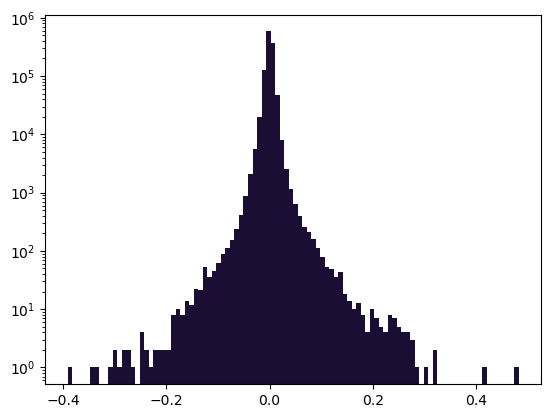

In [55]:
if len(params.shape) == 1:
    hist, edges = params.histogram(bins=100)
else:
    hist, edges = params[-1].histogram(bins=100)
print(params.min(), params.max(), params.mean(), params.std())
plt.bar(edges[:-1], hist, width=edges[1]-edges[0], align='edge')
plt.yscale('log')

In [56]:
mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", palettable.scientific.sequential.Tokyo_8.mpl_colors)

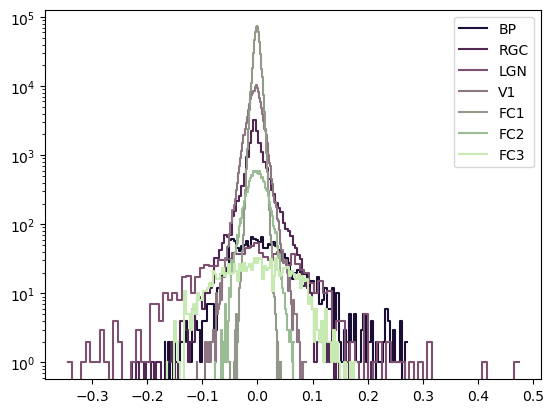

In [57]:
for param in pgroups[-1]:
    if len(param) >= 1024:
        hist, edges = param.histogram(bins=100)
        plt.step(edges[:-1], hist, where='pre')
plt.legend(layernames)#[i for i in range(len(pgroups[-1]))])
plt.yscale('log')

In [58]:
rel_groups = [len(g)>1000 for g in pgroups[-1]]

In [59]:
group_sums=np.array([[group.abs().sum() for group in np.array(epoch_groups, dtype=object)[rel_groups]] for epoch_groups in pgroups])

In [60]:
torch.tensor(pgroups[-1][0].shape)

tensor([1728])

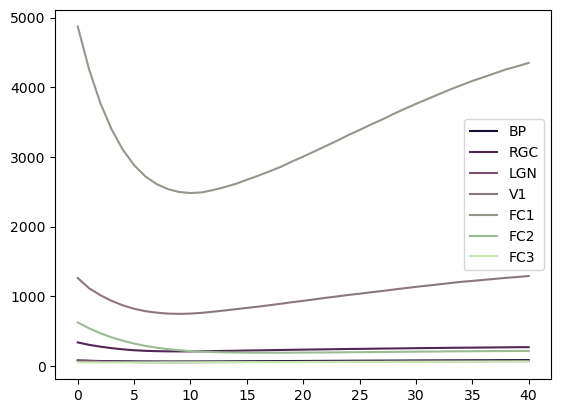

In [61]:
plt.plot(group_sums)
plt.legend(layernames)
plt.show()

In [62]:
if len(params.shape) == 2:
    _min, _max = -params.abs().max(), params.abs().max()
    bins = torch.arange(_min, _max, step=(_max-_min)/200)

    hists = []
    max_val = 0
    for pgroup in pgroups:
        hists.append([])
        edges = []
        for param in pgroup:
            if len(param) >= 1024:
                hist, group_edges = param.histogram(bins=bins)
                hists[-1].append(hist)
                edges.append(group_edges)
                max_val = max(hist.max(), max_val)

    fig = plt.figure()
    steps = []
    for g_hist, g_edges in zip(hists[-1], edges):
        step_line, = plt.step(g_edges[:-1], g_hist, where='pre')
        steps.append(step_line)
    plt.yscale('log')
    plt.ylim(0.1,max_val*1.1)
    plt.legend(layernames)#[i for i in range(len(pgroups[-1]))])

    title = fig.suptitle("Epoch 0", fontsize=16)
    plt.tight_layout()

    def update(frame):
        title.set_text(f"Epoch {frame}")
        for g_hist, g_edges, g_step in zip(hists[frame], edges, steps):
            g_step.set_data(g_edges[:-1], g_hist)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(params), interval=200)
    display(HTML(ani.to_jshtml()))
    plt.close()

In [63]:
if len(params.shape) == 2:
    _min, _max = -params.abs().max(), params.abs().max()
    bins = torch.arange(_min, _max, step=(_max-_min)/200)

    hists = []
    for mparams in params:
        hist, edges = mparams.histogram(bins=bins)
        hists.append(hist)
    hists = torch.stack(hists)

    fig = plt.figure()
    barcollection = plt.bar(edges[:-1], hist, width=edges[1]-edges[0], align='edge')
    plt.yscale('log')
    plt.ylim(0.5,hists.max()*1.1)

    title = fig.suptitle("Epoch 0", fontsize=16)
    plt.tight_layout()

    def update(frame):
        title.set_text(f"Epoch {frame}")
        for i, b in enumerate(barcollection):
            b.set_height(hists[frame][i])

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(params), interval=200)
    display(HTML(ani.to_jshtml()))
    plt.close()

# Weights comparison

In [64]:
mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)

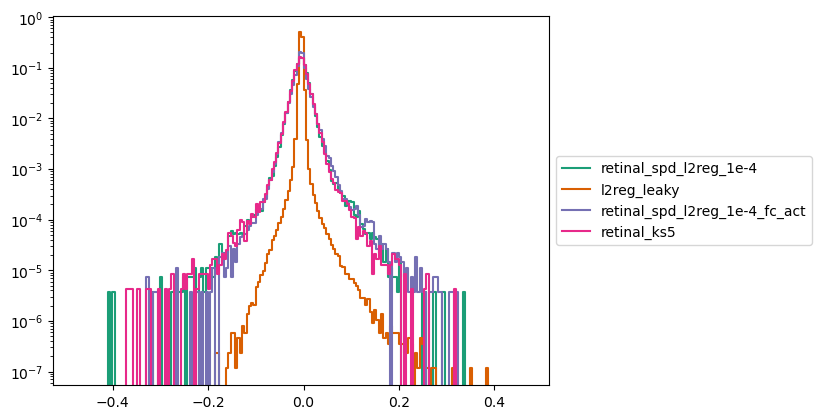

In [68]:
model_paths = ["../models/spd/retinal_spd_l2reg_1e-4","../models/spd/l2reg_leaky", "../models/spd/retinal_spd_l2reg_1e-4_fc_act", "../models/spd_kernel_size/retinal_ks5"]
params = []
for mpath in model_paths:
    model = load_model(mpath).get_sequential()[:]
    params.append(torch.cat([p.detach().cpu().flatten() for p in model.parameters()]))

_max = np.max([param.abs().max() for param in params])
bins = torch.arange(-_max, _max, step=(_max*2)/200)

hists = []
for mparams in params:
    hist, edges = mparams.histogram(bins=bins)
    hists.append(hist)
hists = torch.stack(hists)

for hist in hists:
    plt.step(edges[:-1], hist/hist.sum(), where='pre')
plt.yscale('log')
plt.legend([os.path.split(mpath)[1] for mpath in model_paths], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [66]:
hists.sum(dim=1)

tensor([ 269258., 8679946.,  269257.])